Carga de datos:
Habremos descargado el conjunto de datos Oxford pets del URL https://www.robots.ox.ac.uk/~vgg/data/pets/ y extraído las imágenes a una carpeta images. La siguiente celda organiza los archivos en dos clases (perros y gatos) y en dos subconjuntos (entrenamiento y test) para facilitar las tareas posteriores:

In [2]:
import os
import glob
import re

images_path = "images/images/"
annotations_path = "images/annotations"

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

os.makedirs(os.path.join(images_path, "train", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "dogs"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "cats"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "dogs"), exist_ok=True)

def classify_image(line, subset):
    basename = line.split(" ")[0]
    species = line.split(" ")[2]
    subfolder = "cats" if species == "1" else "dogs"
    oldpath = os.path.join(images_path, f"{basename}.jpg")
    newpath = os.path.join(images_path, subset, subfolder, f"{basename}.jpg")
    if os.path.isfile(oldpath):
        os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")



In [3]:
from keras.preprocessing.image import ImageDataGenerator

generador_entrenamiento = ImageDataGenerator()
datos_entrenamiento = generador_entrenamiento.flow_from_directory("images/images/train")
generador_test = ImageDataGenerator()
datos_test = generador_test.flow_from_directory("images/images/test", class_mode=None)
algunas_imagenes = next(datos_test)

Found 3680 images belonging to 2 classes.
Found 3669 images belonging to 2 classes.


Visualización:
Podemos visualizar algún ejemplo de imagen a continuación:

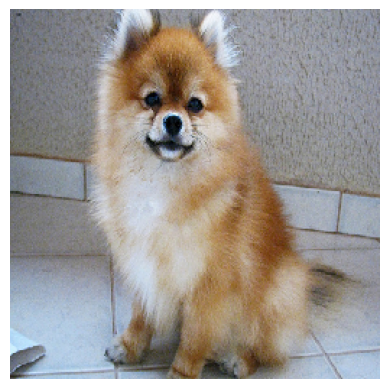

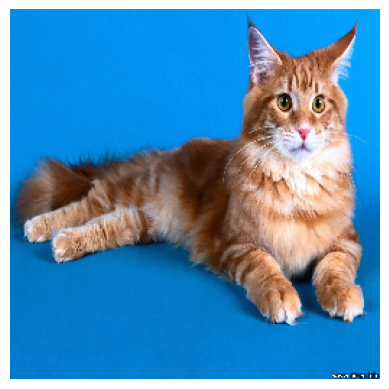

In [4]:
from matplotlib import pyplot as plt
plt.imshow(algunas_imagenes[0]/255.)
plt.axis('off')
plt.show()
plt.imshow(algunas_imagenes[1]/255.)
plt.axis('off')
plt.show()

Carga del modelo:
Nuestro objetivo será crear un modelo capaz de responder a la pregunta "¿Corresponde esta imagen a un gato o a un perro?". En lugar de diseñar una nueva red neuronal desde cero, podemos cargar una red ya construida y, mejor aún, los parámetros optimizados para el conjunto de datos Imagenet de todo tipo de imágenes, de forma que nuestra red viene ya "preparada" para reconocer imágenes y no partimos de cero al entrenar. Esta estrategia se conoce como transfer learning.

Importaremos la red InceptionV3 desde la biblioteca de modelos ya entrenados de Tensorflow. Esta red se basa en un componente llamado "bloque Inception": encadena varios de estos bloques para extraer información de la imagen.

In [5]:
from keras import applications

Inception = applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))


Ajustes del modelo:
En la siguiente celda añadimos a la red InceptionV3 un par de capas que nos permiten obtener una predicción a partir de la información que haya inferido de la imagen.

In [6]:
from keras.layers import Flatten, Dense
from keras.models import Sequential
predictor = Sequential([
    Flatten(), 
    Dense(128, activation="relu"), 
    Dense(2, activation="softmax")
])
modelo = Sequential([Inception, predictor])
modelo.compile(optimizer="adam", loss="categorical_crossentropy")

Entrenamiento
Una vez creado el modelo que ya tiene la estructura final para responder preguntas de "sí/no", ajustamos sus parámetros (que inicialmente son aleatorios) al conjunto de imágenes que vamos a utilizar para entrenar:

In [12]:
modelo.fit(datos_entrenamiento, epochs=50)

Epoch 1/50
115/115 [==============================] - 1005s 9s/step - loss: 1.7496
Epoch 2/50
115/115 [==============================] - 1083s 9s/step - loss: 0.6347
Epoch 3/50
115/115 [==============================] - 624s 5s/step - loss: 0.6347
Epoch 4/50
115/115 [==============================] - 627s 5s/step - loss: 0.6282
Epoch 5/50
115/115 [==============================] - 629s 5s/step - loss: 0.6208
Epoch 6/50
115/115 [==============================] - 642s 6s/step - loss: 0.5999
Epoch 7/50
115/115 [==============================] - 1356s 12s/step - loss: 0.4303
Epoch 8/50
115/115 [==============================] - 1030s 9s/step - loss: 0.2862
Epoch 9/50
115/115 [==============================] - 708s 6s/step - loss: 0.1829
Epoch 10/50
115/115 [==============================] - 719s 6s/step - loss: 0.1358
Epoch 11/50
115/115 [==============================] - 720s 6s/step - loss: 0.1079
Epoch 12/50
115/115 [==============================] - 1165s 10s/step - loss: 0.0934
Epoch 

Predicción:
Nuestro modelo ya está listo. En la siguiente celda tomamos algunas imágenes del subconjunto de test (imágenes que nunca han sido vistas por la red neuronal) y comprobamos cuáles son las predicciones del modelo: ¿acertará todos los perros y gatos?

In [7]:
lote_test = next(datos_test)

probs = modelo.predict(lote_test)
import numpy as np
clase = np.argmax(probs, -1)

1/1 [==============================] - 4s 4s/step


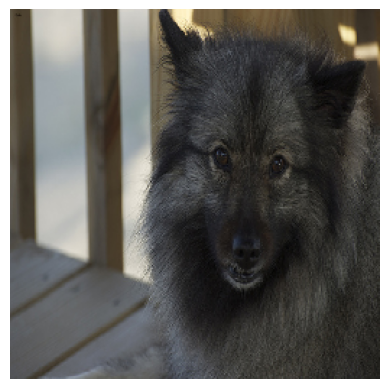

Predicción: gato


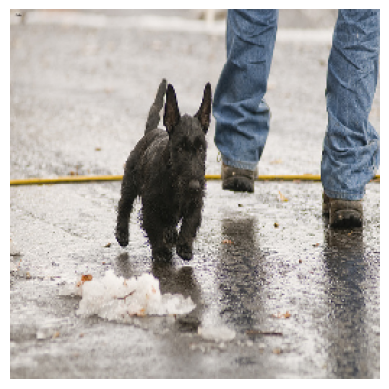

Predicción: gato


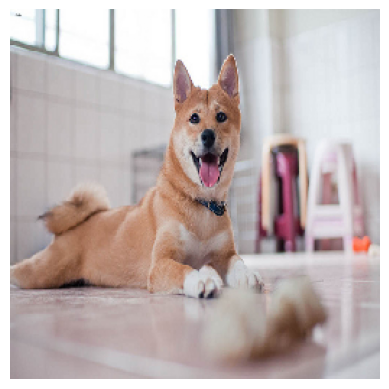

Predicción: gato


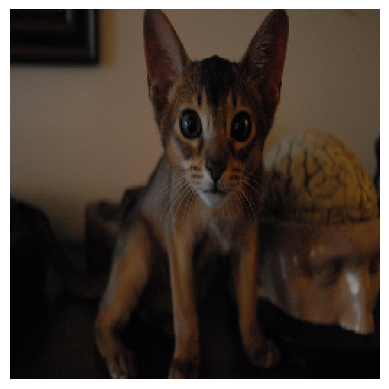

Predicción: gato


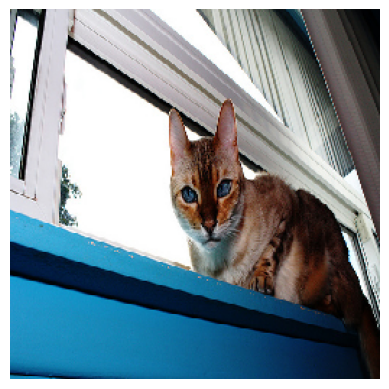

Predicción: gato


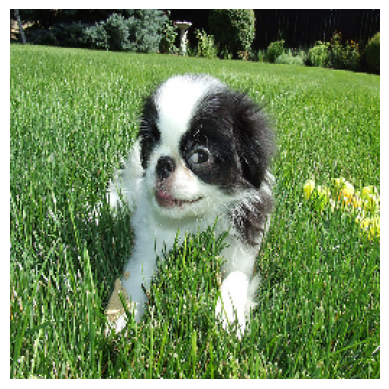

Predicción: gato


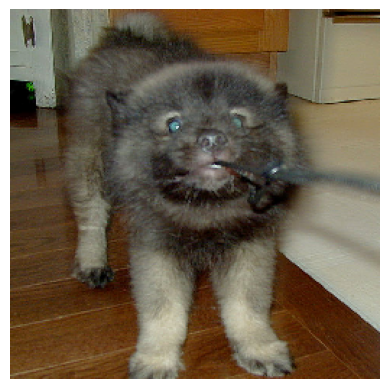

Predicción: gato


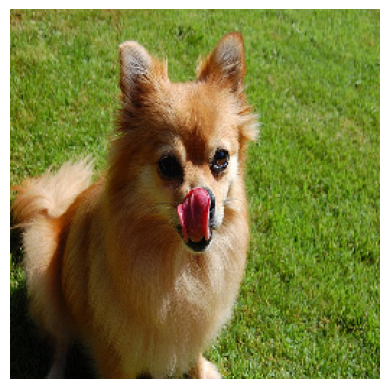

Predicción: perro


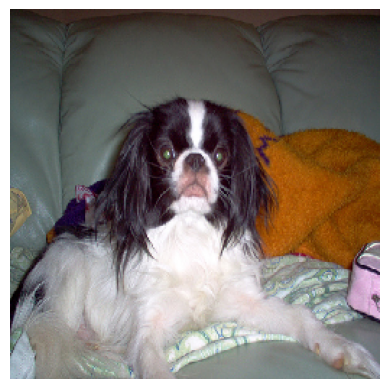

Predicción: gato


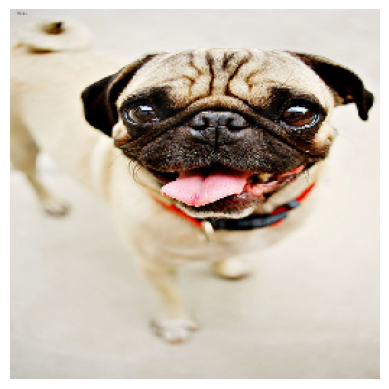

Predicción: gato


In [8]:
mostrar_imagenes = 10

for i in range(mostrar_imagenes):
    plt.imshow(lote_test[i]/255.)
    plt.axis('off')
    plt.show()
    print("Predicción:", "perro" if clase[i] else "gato")